## 1. Importing Packages

In [53]:
import warnings
warnings.filterwarnings("ignore")
import qiskit.tools.jupyter
%qiskit_version_table

In [2]:
import eikon as ek
print("Eikon version: ", ek.__version__)

Eikon version:  1.1.12


In [54]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import qiskit
from qiskit import Aer, QuantumCircuit
from qiskit_finance.data_providers._base_data_provider import BaseDataProvider
from qiskit.finance.applications.ising import portfolio
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA

#### Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first. You can get your api token from [here](https://quantum-computing.ibm.com/)

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

In [55]:
from qiskit import IBMQ
IBMQ.save_account('MY_API_TOKEN', overwrite=True)

#### Setup Eikon API
I have saved my Eikon Data API key in a file for security reason and not displaying here in notebook.

In [5]:
eikon_key = open("eikon.txt","r")
ek.set_app_key(str(eikon_key.read()))
eikon_key.close()

## 2. Getting Data using Eikon API & Pre-Processing

#### Defining EikonDataProvider class for Loading Data as needed by Qiskit
We will inherit BaseDataProvider from data provider module of Qiskit Finance to extend it's functionality of getting data from Eikon API in desired format and make use of existing functions.

In [6]:
class EikonDataProvider(BaseDataProvider):
    """
    The abstract base class for Eikon data_provider.
    """
    def __init__(self, stocks_list, start_date, end_date):
        '''
        stocks -> List of interested assets
        start -> start date to fetch historical data
        end -> 
        '''
        super().__init__()
        self._stocks = stocks_list
        self._start = start_date
        self._end = end_date
        self._data = []
        self.stock_data = pd.DataFrame()
        
    def run(self):
        self._data = []
        stocks_notfound = []
        stock_data = ek.get_timeseries(self._stocks,
                  start_date=self._start, 
                  end_date=self._end, 
                  interval='daily',
                  corax='adjusted')
        for ticker in self._stocks:
            stock_value = stock_data['CLOSE']
            self.stock_data[ticker] = stock_data['CLOSE']
            if stock_value.dropna().empty:
                stocks_notfound.append(ticker)
            self._data.append(stock_value)

### Initializing Required Parameters

In [7]:
# List of stocks 
stock_list = ['FB.O']

# Start Date
start_date = datetime.datetime(2020,12,1)

# End Date
end_date = datetime.datetime(2021,12,1)

# Set number of equities to the number of stocks
num_assets = len(stock_list)

# Set the risk factor
risk_factor = 0.7

# Set budget
budget = 2

# Scaling of budget penalty term will be dependant on the number of assets
penalty = num_assets

### Getting data from Eikon API using EikonDataProvider class

In [8]:
data = EikonDataProvider(stocks_list = stock_list, start_date=start_date, end_date=end_date)
data.run()

In [9]:
# Top 5 rows of data 
df = data.stock_data
df.head()

,FB.O
Date,
2020-12-01,286.55
2020-12-02,287.52
2020-12-03,281.85
2020-12-04,279.7
2020-12-07,285.58


In [10]:
df.describe()

,FB.O
count,253.000000
mean,316.401403
std,36.680760
min,245.640000
25%,278.010000
50%,324.630000
75%,343.180000
max,382.180000


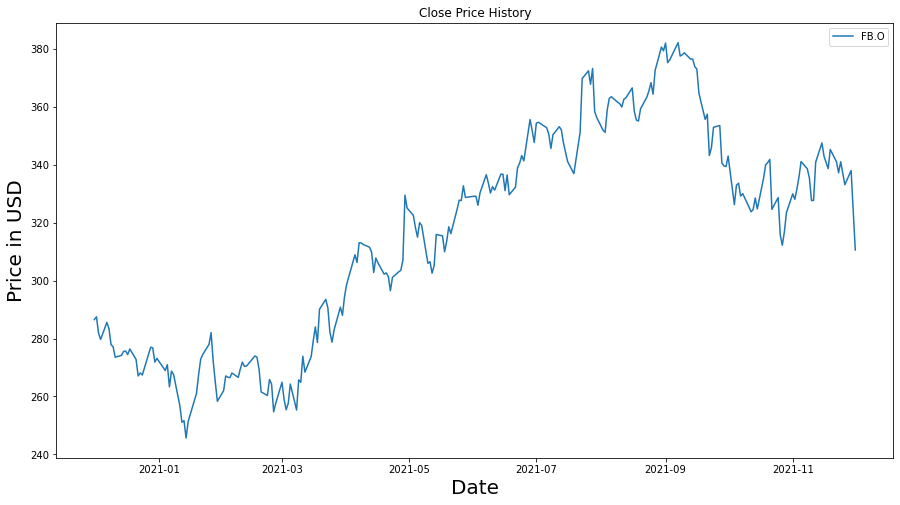

In [11]:
# Closing Price History
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df)
plt.title('Close Price History')
plt.xlabel('Date',fontsize =20)
plt.ylabel('Price in USD',fontsize = 20)
ax.legend(df.columns.values)
plt.show()

For the purposes of this article we are going to direct our attention towards the Qiskit Finance application module by IBM, more specifically we are going to look at the quantum computing approach for pricing European Call options. In the Qiskit tutorial we can look at the gradual construction of a circuit specific for European Call.

In [12]:
df.tail()

,FB.O
Date,
2021-11-24,341.06
2021-11-26,333.12
2021-11-29,338.03
2021-11-30,324.46
2021-12-01,310.6


In [13]:
strike_price = 315   # agreed upon strike price
T = 40 / 253         # 40 days to maturity

S = 310.6              # initial spot price
# vol = 0.4            # volatility of 40%
vol = df['FB.O'].pct_change().std()
r = 0.05             # annual interest rate of 4%

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

In [14]:
low

306.2211877059792

In [15]:
high

319.90894524815974

In [16]:
import numpy as np
from qiskit.algorithms import AmplitudeEstimation
from qiskit_finance.circuit.library import EuropeanCallPricingObjective  # F
from qiskit.circuit.library import LogNormalDistribution, NormalDistribution
from qiskit_finance.applications import EuropeanCallPricing
from qiskit_finance.applications.estimation import EuropeanCallDelta
from qiskit import Aer
from qiskit.algorithms import IterativeAmplitudeEstimation

In [17]:
provider = IBMQ.load_account() 
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [56]:
backend = provider.get_backend("ibmq_lima")
sim = QuantumInstance(backend=backend, shots=1000)

#### Due to limitation in number of publicly available qubits of IBMQ systems, we will be using 2 qubits to test it on real quantum computer. 

In [19]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 2

## 3. Log Normal Distribution

### Call Option

In [20]:
distribution = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

In [21]:
european_call_pricing = EuropeanCallPricing(num_state_qubits=num_uncertainty_qubits,
                                            strike_price=strike_price,
                                            rescaling_factor=0.25,  # approximation constant for payoff function
                                            bounds=(low, high),
                                            uncertainty_model=distribution)

In [22]:
problem = european_call_pricing.to_estimation_problem()

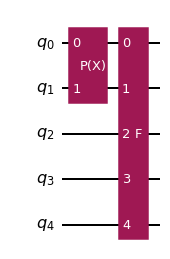

In [23]:
problem.state_preparation.draw('mpl', style='iqx')
plt.show()

In this diagram, we see implementation of the Log-normal distribution on the first layer and Linear Amplitude Estimation function on the second layer. In both European call and European put implementations a central algorithm is Iterative Amplitude Estimation. Crucially, this implementation does not rely on Quantum Phase Estimation, instead it bases only on select Grover iterations. Essentially, we are interested in the probability of measuring ∣1⟩ in the last qubit.

In [24]:
epsilon = 0.01  # determines final accuracy
alpha = 0.05  # determines how certain we are of the result

ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=sim)

In [57]:
result = ae.estimate(problem)

In [26]:
conf_int_result = np.array(result.confidence_interval_processed)
print("Esimated value: \t%.4f" % european_call_pricing.interpret(result))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int_result))

Esimated value: 	2.5420
Confidence interval: 	[2.4652, 2.6188]


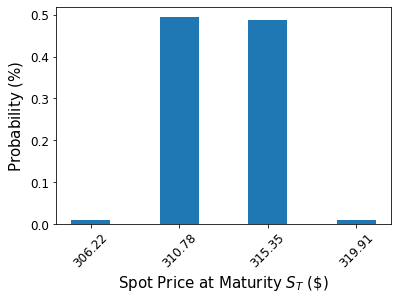

In [49]:
x = distribution.values
y = distribution.probabilities
plt.figure(figsize=(6,4))
plt.bar(x, y, width=2)
plt.xticks(x, size=12, rotation=45)
plt.yticks(size=12)
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

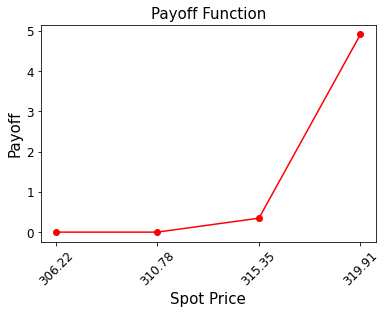

In [50]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = distribution.values
y = np.maximum(0, x - strike_price)
plt.figure(figsize=(6,4))
plt.plot(x, y, "ro-")
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=12, rotation=45)
plt.yticks(size=12)
plt.show()

In [29]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(distribution.probabilities, y)
exact_delta = sum(distribution.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.2159
exact delta value:   	0.4970


### Evaluate Delta

The Delta is a bit simpler to evaluate than the expected payoff. Similarly to the expected payoff, we use a comparator circuit and an ancilla qubit to identify the cases. However, since we are only interested in the probability of this condition being true, we can directly use this ancilla qubit as the objective qubit in amplitude estimation without any further approximation.

In [30]:
european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=distribution,
)

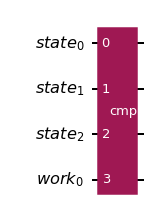

In [31]:
european_call_delta._objective.decompose().draw('mpl', style='iqx')
plt.show()

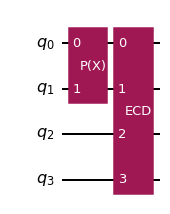

In [32]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(distribution, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw('mpl', style='iqx')
plt.show()

In [33]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=sim)

In [34]:
result_delta = ae_delta.estimate(problem)

In [35]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Esimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.4970
Esimated value: 	0.5023
Confidence interval: 	[0.4976, 0.5071]
